# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [ ]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        x = F.relu(self.fc1(x))
        means = self.fc2(x)
        log_variances = self.fc22(x)
        # means = torch.randn(x.shape[0], 20).to(device)
        # log_variances = torch.randn(x.shape[0], 20).to(device)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        # embedding = torch.randn(means.shape[0], 20).to(device)
        expo = torch.exp(log_variances * 0.5)
        embedding = means + torch.randn_like(expo) * expo
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        z = F.relu(self.fc3(z))
        probabilties = torch.sigmoid(self.fc4(z))
        # probabilties = torch.rand(z.shape[0],784).to(device)
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):

        # probabilties = torch.rand(x.shape[0],20).to(device)
        # means = torch.randn(x.shape[0], 20).to(device)
        # log_variances = torch.randn(x.shape[0], 20).to(device)
        means, log_variances = self.encode(x.view(-1, 784))
        rep = self.reparameterize(means, log_variances)
        return self.decode(rep), means, log_variances

# Loss Functions

In [ ]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    total_loss = BCE - 0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    return total_loss, BCE


# Training

In [ ]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
  train_BCE = 0
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, log_variances = model(data)
    loss, BCE = vae_loss_function(recon_batch, data, mu, log_variances)
    loss.backward()
    train_loss += loss.item()
    train_BCE += BCE.item()
    optimizer.step()
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader),
              loss.item() / len(data)))
  average_train_BCE = train_BCE / len(train_loader.dataset)
  average_train_loss = train_loss / len(train_loader.dataset)
  print('====> Epoch: {} Average loss: {:.4f} Average BCE: {:.4f}'.format(
        epoch, average_train_loss, average_train_BCE))
  return average_train_loss, average_train_BCE



# Testing

In [ ]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
  model.eval()
  test_BCE = 0
  test_loss = 0
  with torch.no_grad():
      for i, (data, _) in enumerate(test_loader):
          data = data.to(device)
          recon_batch, mu, log_variances = model(data)
          loss, BCE = vae_loss_function(recon_batch, data, mu, log_variances)
          test_loss += loss.item()
          test_BCE += BCE.item()
          if i == 0:
              n = min(data.size(0), 8)
              comparison = torch.cat([data[:n],
                                    recon_batch.view(batch_size, 1, 28, 28)[:n]])
              save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
              print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
              display(Image('results/reconstruction_' + str(epoch) + '.png'))
    
  average_test_loss = test_loss / len(test_loader.dataset)
  average_test_BCE = test_BCE / len(test_loader.dataset)
  print('====> Test set loss: {:.4f} Test set BCE: {:.4f}'.format(average_test_loss, average_test_BCE))
  return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.111145
Train Epoch: 1 [12800/60000 (21%)]	Loss: 220.672577
Train Epoch: 1 [25600/60000 (43%)]	Loss: 208.011841
Train Epoch: 1 [38400/60000 (64%)]	Loss: 185.240509
Train Epoch: 1 [51200/60000 (85%)]	Loss: 166.680664
====> Epoch: 1 Average loss: 231.2988
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


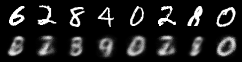

====> Test set loss: 158.8992
Sample of generated images


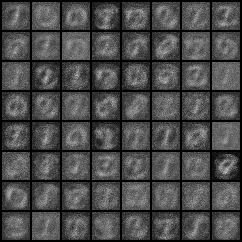



Train Epoch: 2 [0/60000 (0%)]	Loss: 157.860260
Train Epoch: 2 [12800/60000 (21%)]	Loss: 153.357025
Train Epoch: 2 [25600/60000 (43%)]	Loss: 139.674301
Train Epoch: 2 [38400/60000 (64%)]	Loss: 134.562347
Train Epoch: 2 [51200/60000 (85%)]	Loss: 123.958786
====> Epoch: 2 Average loss: 140.2839
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


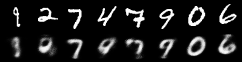

====> Test set loss: 124.8009
Sample of generated images


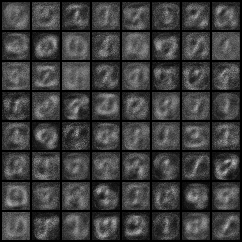



Train Epoch: 3 [0/60000 (0%)]	Loss: 123.569252
Train Epoch: 3 [12800/60000 (21%)]	Loss: 121.158340
Train Epoch: 3 [25600/60000 (43%)]	Loss: 112.279106
Train Epoch: 3 [38400/60000 (64%)]	Loss: 120.166763
Train Epoch: 3 [51200/60000 (85%)]	Loss: 111.691589
====> Epoch: 3 Average loss: 116.7407
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


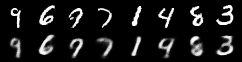

====> Test set loss: 107.6055
Sample of generated images


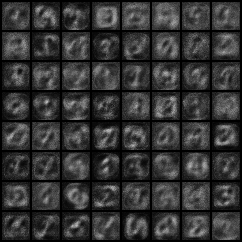



Train Epoch: 4 [0/60000 (0%)]	Loss: 110.107468
Train Epoch: 4 [12800/60000 (21%)]	Loss: 104.921967
Train Epoch: 4 [25600/60000 (43%)]	Loss: 104.642731
Train Epoch: 4 [38400/60000 (64%)]	Loss: 98.829185
Train Epoch: 4 [51200/60000 (85%)]	Loss: 99.321320
====> Epoch: 4 Average loss: 103.5815
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


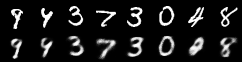

====> Test set loss: 98.0708
Sample of generated images


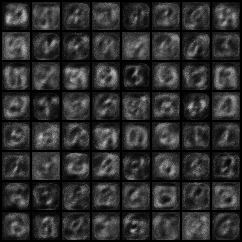



Train Epoch: 5 [0/60000 (0%)]	Loss: 99.575668
Train Epoch: 5 [12800/60000 (21%)]	Loss: 96.073296
Train Epoch: 5 [25600/60000 (43%)]	Loss: 99.353867
Train Epoch: 5 [38400/60000 (64%)]	Loss: 94.622849
Train Epoch: 5 [51200/60000 (85%)]	Loss: 97.401749
====> Epoch: 5 Average loss: 96.4248
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


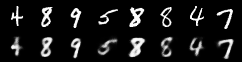

====> Test set loss: 92.5976
Sample of generated images


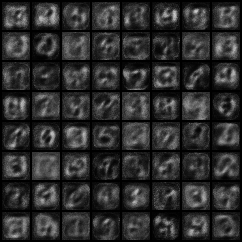



Train Epoch: 6 [0/60000 (0%)]	Loss: 97.361420
Train Epoch: 6 [12800/60000 (21%)]	Loss: 94.719223
Train Epoch: 6 [25600/60000 (43%)]	Loss: 93.154121
Train Epoch: 6 [38400/60000 (64%)]	Loss: 89.295517
Train Epoch: 6 [51200/60000 (85%)]	Loss: 91.231819
====> Epoch: 6 Average loss: 91.9295
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


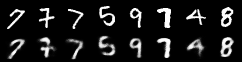

====> Test set loss: 88.9400
Sample of generated images


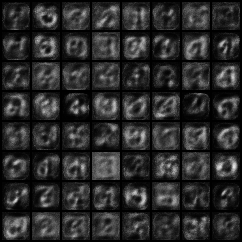



Train Epoch: 7 [0/60000 (0%)]	Loss: 89.268768
Train Epoch: 7 [12800/60000 (21%)]	Loss: 93.767097
Train Epoch: 7 [25600/60000 (43%)]	Loss: 89.674011
Train Epoch: 7 [38400/60000 (64%)]	Loss: 89.391998
Train Epoch: 7 [51200/60000 (85%)]	Loss: 89.753082
====> Epoch: 7 Average loss: 88.5358
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


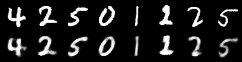

====> Test set loss: 85.9762
Sample of generated images


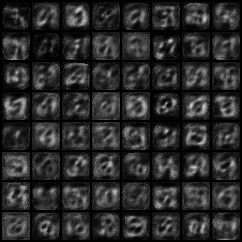



Train Epoch: 8 [0/60000 (0%)]	Loss: 87.773651
Train Epoch: 8 [12800/60000 (21%)]	Loss: 89.527672
Train Epoch: 8 [25600/60000 (43%)]	Loss: 82.360672
Train Epoch: 8 [38400/60000 (64%)]	Loss: 86.675888
Train Epoch: 8 [51200/60000 (85%)]	Loss: 84.438866
====> Epoch: 8 Average loss: 85.9810
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


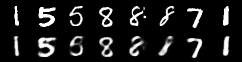

====> Test set loss: 83.7724
Sample of generated images


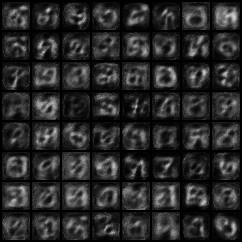



Train Epoch: 9 [0/60000 (0%)]	Loss: 84.643433
Train Epoch: 9 [12800/60000 (21%)]	Loss: 86.079102
Train Epoch: 9 [25600/60000 (43%)]	Loss: 87.957161
Train Epoch: 9 [38400/60000 (64%)]	Loss: 81.013245
Train Epoch: 9 [51200/60000 (85%)]	Loss: 85.230385
====> Epoch: 9 Average loss: 83.9509
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


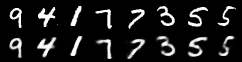

====> Test set loss: 81.9881
Sample of generated images


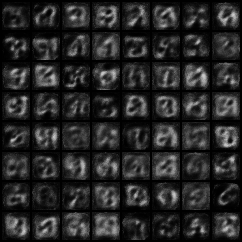



Train Epoch: 10 [0/60000 (0%)]	Loss: 81.645103
Train Epoch: 10 [12800/60000 (21%)]	Loss: 83.541916
Train Epoch: 10 [25600/60000 (43%)]	Loss: 78.130096
Train Epoch: 10 [38400/60000 (64%)]	Loss: 80.647591
Train Epoch: 10 [51200/60000 (85%)]	Loss: 81.739716
====> Epoch: 10 Average loss: 82.2453
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


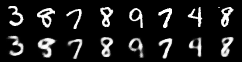

====> Test set loss: 80.4761
Sample of generated images


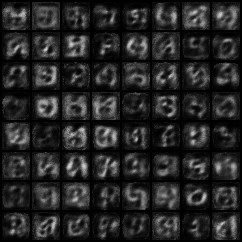



Train Epoch: 1 [0/60000 (0%)]	Loss: 551.327271
Train Epoch: 1 [12800/60000 (21%)]	Loss: 271.716003
Train Epoch: 1 [25600/60000 (43%)]	Loss: 232.631699
Train Epoch: 1 [38400/60000 (64%)]	Loss: 214.303665
Train Epoch: 1 [51200/60000 (85%)]	Loss: 213.536392
====> Epoch: 1 Average loss: 260.4981 Average BCE: 243.9266
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


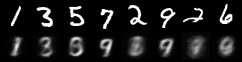

====> Test set loss: 194.7237 Test set BCE: 178.5505
Sample of generated images


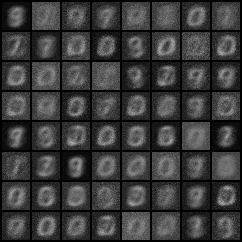



Train Epoch: 2 [0/60000 (0%)]	Loss: 194.596268
Train Epoch: 2 [12800/60000 (21%)]	Loss: 185.588058
Train Epoch: 2 [25600/60000 (43%)]	Loss: 176.157776
Train Epoch: 2 [38400/60000 (64%)]	Loss: 172.070267
Train Epoch: 2 [51200/60000 (85%)]	Loss: 167.180634
====> Epoch: 2 Average loss: 177.4686 Average BCE: 160.7105
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


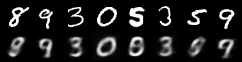

====> Test set loss: 163.8170 Test set BCE: 145.8208
Sample of generated images


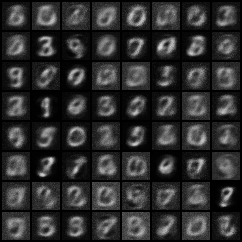



Train Epoch: 3 [0/60000 (0%)]	Loss: 170.791458
Train Epoch: 3 [12800/60000 (21%)]	Loss: 158.635193
Train Epoch: 3 [25600/60000 (43%)]	Loss: 161.164017
Train Epoch: 3 [38400/60000 (64%)]	Loss: 154.760208
Train Epoch: 3 [51200/60000 (85%)]	Loss: 156.593979
====> Epoch: 3 Average loss: 157.9807 Average BCE: 139.7998
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


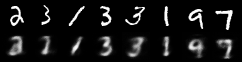

====> Test set loss: 151.2384 Test set BCE: 132.3658
Sample of generated images


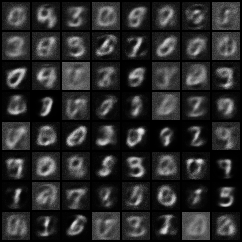



Train Epoch: 4 [0/60000 (0%)]	Loss: 152.288300
Train Epoch: 4 [12800/60000 (21%)]	Loss: 152.291763
Train Epoch: 4 [25600/60000 (43%)]	Loss: 144.307388
Train Epoch: 4 [38400/60000 (64%)]	Loss: 148.811859
Train Epoch: 4 [51200/60000 (85%)]	Loss: 145.539810
====> Epoch: 4 Average loss: 146.8200 Average BCE: 127.2400
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


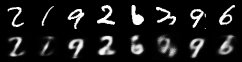

====> Test set loss: 141.1640 Test set BCE: 120.3650
Sample of generated images


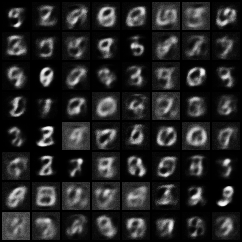



Train Epoch: 5 [0/60000 (0%)]	Loss: 148.850693
Train Epoch: 5 [12800/60000 (21%)]	Loss: 147.141785
Train Epoch: 5 [25600/60000 (43%)]	Loss: 127.634827
Train Epoch: 5 [38400/60000 (64%)]	Loss: 138.251068
Train Epoch: 5 [51200/60000 (85%)]	Loss: 130.608826
====> Epoch: 5 Average loss: 138.9367 Average BCE: 118.0779
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


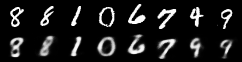

====> Test set loss: 134.7138 Test set BCE: 112.9484
Sample of generated images


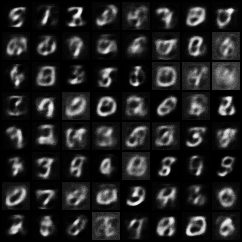



Train Epoch: 6 [0/60000 (0%)]	Loss: 143.581635
Train Epoch: 6 [12800/60000 (21%)]	Loss: 133.771332
Train Epoch: 6 [25600/60000 (43%)]	Loss: 134.787109
Train Epoch: 6 [38400/60000 (64%)]	Loss: 129.527939
Train Epoch: 6 [51200/60000 (85%)]	Loss: 131.249939
====> Epoch: 6 Average loss: 133.3170 Average BCE: 111.6443
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


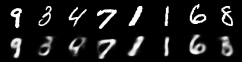

====> Test set loss: 129.9527 Test set BCE: 107.5603
Sample of generated images


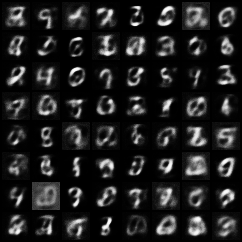



Train Epoch: 7 [0/60000 (0%)]	Loss: 133.435410
Train Epoch: 7 [12800/60000 (21%)]	Loss: 132.830765
Train Epoch: 7 [25600/60000 (43%)]	Loss: 130.501801
Train Epoch: 7 [38400/60000 (64%)]	Loss: 128.284607
Train Epoch: 7 [51200/60000 (85%)]	Loss: 133.198395
====> Epoch: 7 Average loss: 129.3120 Average BCE: 107.0940
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


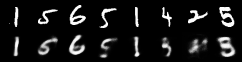

====> Test set loss: 126.5727 Test set BCE: 103.5506
Sample of generated images


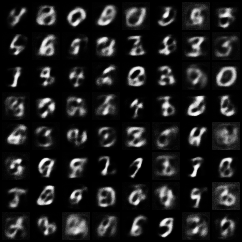



Train Epoch: 8 [0/60000 (0%)]	Loss: 128.538651
Train Epoch: 8 [12800/60000 (21%)]	Loss: 126.566338
Train Epoch: 8 [25600/60000 (43%)]	Loss: 126.385384
Train Epoch: 8 [38400/60000 (64%)]	Loss: 128.747101
Train Epoch: 8 [51200/60000 (85%)]	Loss: 125.427841
====> Epoch: 8 Average loss: 126.2870 Average BCE: 103.6205
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


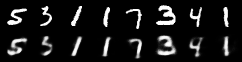

====> Test set loss: 123.7626 Test set BCE: 100.7901
Sample of generated images


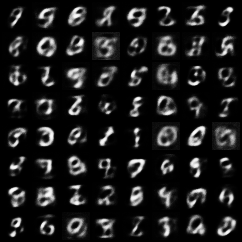



Train Epoch: 9 [0/60000 (0%)]	Loss: 122.514252
Train Epoch: 9 [12800/60000 (21%)]	Loss: 121.708374
Train Epoch: 9 [25600/60000 (43%)]	Loss: 120.512993
Train Epoch: 9 [38400/60000 (64%)]	Loss: 123.450775
Train Epoch: 9 [51200/60000 (85%)]	Loss: 124.539452
====> Epoch: 9 Average loss: 123.7942 Average BCE: 100.8703
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


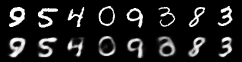

====> Test set loss: 121.5292 Test set BCE: 98.1451
Sample of generated images


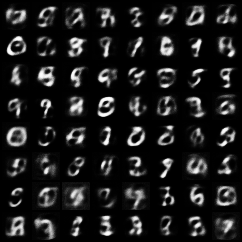



Train Epoch: 10 [0/60000 (0%)]	Loss: 119.161270
Train Epoch: 10 [12800/60000 (21%)]	Loss: 124.757545
Train Epoch: 10 [25600/60000 (43%)]	Loss: 128.958328
Train Epoch: 10 [38400/60000 (64%)]	Loss: 121.294960
Train Epoch: 10 [51200/60000 (85%)]	Loss: 119.204506
====> Epoch: 10 Average loss: 121.7328 Average BCE: 98.5094
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


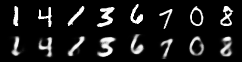

====> Test set loss: 119.7558 Test set BCE: 96.2294
Sample of generated images


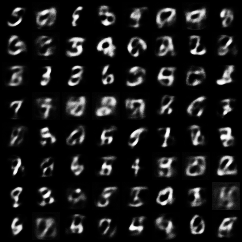

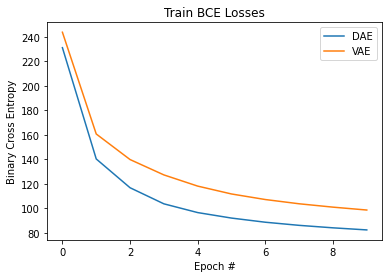

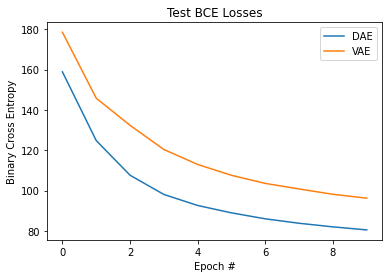

In [ ]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-4)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

#### In both graphs, DAE has lower training loss and testing loss. However, images generated by VAE are better. Comapred to DAE, VAE adds a layer of data means and standard deviation so that the samples are closed to the embeddings of real images. VAE is regularized with normal distribution. It has higher loss because the calculation involves the additional term, KL divergence between inferred latent distribution and Gaussian. 

## Train with SGD

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.987305
Train Epoch: 1 [12800/60000 (21%)]	Loss: 195.338516
Train Epoch: 1 [25600/60000 (43%)]	Loss: 171.713440
Train Epoch: 1 [38400/60000 (64%)]	Loss: 168.336670
Train Epoch: 1 [51200/60000 (85%)]	Loss: 157.283142
====> Epoch: 1 Average loss: 182.6975 Average BCE: 169.9662
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


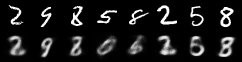

====> Test set loss: 149.6227 Test set BCE: 134.0500
Sample of generated images


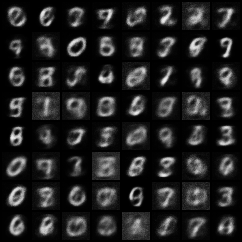



Train Epoch: 2 [0/60000 (0%)]	Loss: 150.029816
Train Epoch: 2 [12800/60000 (21%)]	Loss: 148.983093
Train Epoch: 2 [25600/60000 (43%)]	Loss: 151.802826
Train Epoch: 2 [38400/60000 (64%)]	Loss: 140.028717
Train Epoch: 2 [51200/60000 (85%)]	Loss: 148.757080
====> Epoch: 2 Average loss: 144.8246 Average BCE: 126.5314
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


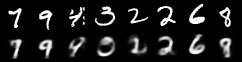

====> Test set loss: 132.6323 Test set BCE: 113.4008
Sample of generated images


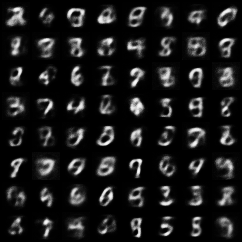



Train Epoch: 3 [0/60000 (0%)]	Loss: 135.943481
Train Epoch: 3 [12800/60000 (21%)]	Loss: 129.991119
Train Epoch: 3 [25600/60000 (43%)]	Loss: 128.705185
Train Epoch: 3 [38400/60000 (64%)]	Loss: 132.240097
Train Epoch: 3 [51200/60000 (85%)]	Loss: 132.702103
====> Epoch: 3 Average loss: 133.4032 Average BCE: 112.9747
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


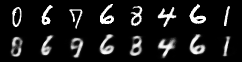

====> Test set loss: 124.8783 Test set BCE: 103.6954
Sample of generated images


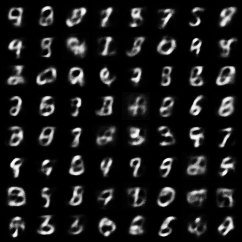



Train Epoch: 4 [0/60000 (0%)]	Loss: 127.530716
Train Epoch: 4 [12800/60000 (21%)]	Loss: 121.826691
Train Epoch: 4 [25600/60000 (43%)]	Loss: 124.704056
Train Epoch: 4 [38400/60000 (64%)]	Loss: 126.755569
Train Epoch: 4 [51200/60000 (85%)]	Loss: 123.581650
====> Epoch: 4 Average loss: 126.8730 Average BCE: 105.1312
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


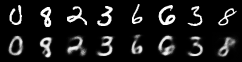

====> Test set loss: 121.7407 Test set BCE: 100.8632
Sample of generated images


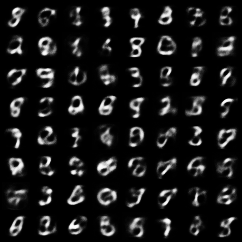



Train Epoch: 5 [0/60000 (0%)]	Loss: 122.019707
Train Epoch: 5 [12800/60000 (21%)]	Loss: 126.282959
Train Epoch: 5 [25600/60000 (43%)]	Loss: 117.839119
Train Epoch: 5 [38400/60000 (64%)]	Loss: 121.491989
Train Epoch: 5 [51200/60000 (85%)]	Loss: 120.589706
====> Epoch: 5 Average loss: 122.8091 Average BCE: 100.2813
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


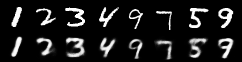

====> Test set loss: 118.2922 Test set BCE: 94.7568
Sample of generated images


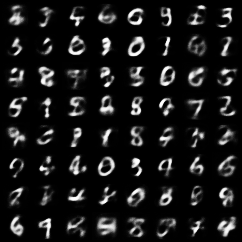



Train Epoch: 6 [0/60000 (0%)]	Loss: 123.149445
Train Epoch: 6 [12800/60000 (21%)]	Loss: 126.701157
Train Epoch: 6 [25600/60000 (43%)]	Loss: 125.234436
Train Epoch: 6 [38400/60000 (64%)]	Loss: 119.715530
Train Epoch: 6 [51200/60000 (85%)]	Loss: 123.541725
====> Epoch: 6 Average loss: 119.9288 Average BCE: 96.8758
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


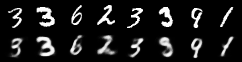

====> Test set loss: 115.2030 Test set BCE: 91.8264
Sample of generated images


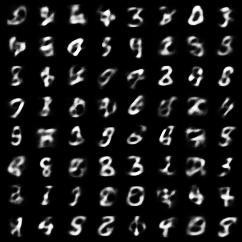



Train Epoch: 7 [0/60000 (0%)]	Loss: 114.570618
Train Epoch: 7 [12800/60000 (21%)]	Loss: 119.014847
Train Epoch: 7 [25600/60000 (43%)]	Loss: 113.870529
Train Epoch: 7 [38400/60000 (64%)]	Loss: 116.111069
Train Epoch: 7 [51200/60000 (85%)]	Loss: 115.542534
====> Epoch: 7 Average loss: 118.2206 Average BCE: 94.7884
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


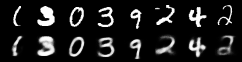

====> Test set loss: 114.3526 Test set BCE: 90.6551
Sample of generated images


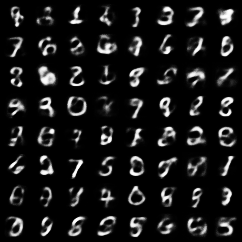



Train Epoch: 8 [0/60000 (0%)]	Loss: 116.279709
Train Epoch: 8 [12800/60000 (21%)]	Loss: 119.548470
Train Epoch: 8 [25600/60000 (43%)]	Loss: 115.847786
Train Epoch: 8 [38400/60000 (64%)]	Loss: 116.977242
Train Epoch: 8 [51200/60000 (85%)]	Loss: 110.924660
====> Epoch: 8 Average loss: 116.7328 Average BCE: 93.0911
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


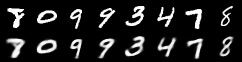

====> Test set loss: 113.3324 Test set BCE: 89.5977
Sample of generated images


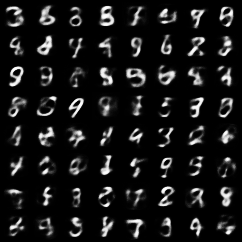



Train Epoch: 9 [0/60000 (0%)]	Loss: 113.404732
Train Epoch: 9 [12800/60000 (21%)]	Loss: 118.603661
Train Epoch: 9 [25600/60000 (43%)]	Loss: 120.531441
Train Epoch: 9 [38400/60000 (64%)]	Loss: 118.497864
Train Epoch: 9 [51200/60000 (85%)]	Loss: 114.502274
====> Epoch: 9 Average loss: 115.5256 Average BCE: 91.7406
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


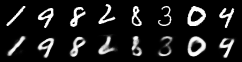

====> Test set loss: 112.6876 Test set BCE: 88.0323
Sample of generated images


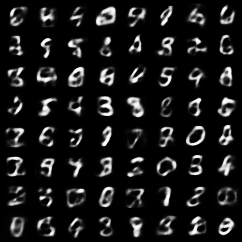



Train Epoch: 10 [0/60000 (0%)]	Loss: 112.404076
Train Epoch: 10 [12800/60000 (21%)]	Loss: 114.778870
Train Epoch: 10 [25600/60000 (43%)]	Loss: 112.025253
Train Epoch: 10 [38400/60000 (64%)]	Loss: 109.800041
Train Epoch: 10 [51200/60000 (85%)]	Loss: 115.808403
====> Epoch: 10 Average loss: 114.7227 Average BCE: 90.7838
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


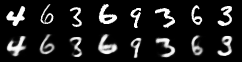

====> Test set loss: 111.5450 Test set BCE: 88.3577
Sample of generated images


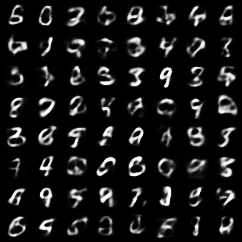

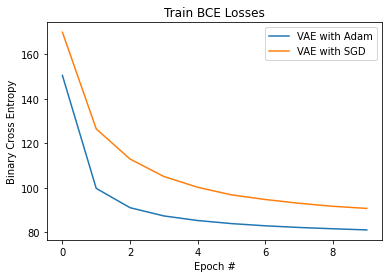

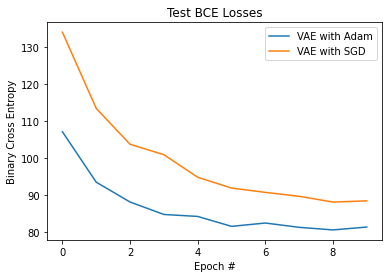

In [ ]:
# train and test VAE
epochs = 10
vae_average_train_losses1 = []
vae_average_train_BCE1 = []
vae_average_test_losses1 = []
vae_average_test_BCE1 = []
vae_model = VAE().to(device)
vae_optimizer = optim.SGD(vae_model.parameters(), lr=1e-4)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses1.append(average_train_loss)
    vae_average_train_BCE1.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses1.append(average_test_loss)
    vae_average_test_BCE1.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(vae_average_train_BCE)
plt.plot(vae_average_train_BCE1)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['VAE with Adam','VAE with SGD'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(vae_average_test_BCE)
plt.plot(vae_average_test_BCE1)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['VAE with Adam','VAE with SGD'], loc='upper right')
plt.show()

#### Adam optimizer is preferred with lower training and testing loss.

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('cs480_winter22_asst5_vae_skeleton.ipynb')

--2022-04-05 06:48:45--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-04-05 06:48:45 (28.6 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

